# Introduction: Galaxy Optical Morphology

In 1926, Edwin Hubble devised a scheme, known as the **Hubble Sequence**, to classify galaxies based on their visual morphology. The Hubble Sequence divides galaxies into **ellipticals, spirals, irregulars and lenticulars**, which represent the transition between ellipticals and spirals.

The Hubble Sequence matters because galaxy properties meaningfully vary between Hubble types. Ellipticals are typically larger, brighter, older than spirals and irregulars. Spiral galaxies have distinct disk and bulge structures, and the study of stellar kinematics in spirals helped scientists uncover the existence of mysterious dark matter, one of the biggest enigmas in modern astronomy. Irregular galaxies, by contrast, can sometimes have surprisingly high star formation rates and violent evolutionary histories. 

Understanding how the relative abundance of galaxies of different morphological types changed over cosmic time is key to reconstructing the **formation and evolution of galaxies**, and by extension, the history of the universe itself.

# Aim: Galaxy Classification

In this project, I aim to create a neural network algorithm to **accurately classify galaxies**. I will use the **Galaxy10 dataset**, which consists of ~18,000 galaxy images manually classified into ten galaxy classes, inspired by the Hubble Sequence.

Through this exercise, I would like to familiarize myself with the **deep learning workflow**, including data preprocessing and augmentation, model protyping and iteration, performance benchmarking, and model selection and evaluation. 

# Galaxy10 Dataset 

The Galaxy10 dataset contains 17,736 galaxy images, with a resolution of 256x256 pixels and three color channels. Each galaxy is classified into one of ten classes: *Disturbed, Merging, Round Smooth, In-between Round Smooth, Cigar Shaped Smooth, Barred Spiral, Unbarred Tight Spiral, Unbarred Loose Spiral, Edge-on without Bulge and Edge-on with Bulge*. 

The class distribution is **moderately imbalanced**: Most classes have between 1800 to 2600 samples, but the *Cigar Shaped Smooth* and *Disturbed* classes are significantly underrepresented with only 334 and 1081 samples, respectively. (Source: https://astronn.readthedocs.io/en/latest/galaxy10.html).

In [ ]:
# Load images and labels (will download automatically the first time)
# First time downloading location will be ~/.astroNN/datasets/
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
from astroNN.datasets import load_galaxy10
from tensorflow.keras import utils
import numpy as np


images, labels = load_galaxy10()

# Convert the labels to categorical 10 classes
labels_categorical = utils.to_categorical(labels, 10)

# Convert to desirable type
labels_categorical = labels_categorical.astype(np.float32)
images = images.astype(np.float32)

In [3]:
# Print some basic information
n, width, height, n_colors = images.shape
print(f'Number of data points: {n}')
print(f'Width of images: {width}')
print(f'Height of images: {height}')
print(f'Number of colors: {n_colors}')

Number of data points: 17736
Width of images: 256
Height of images: 256
Number of colors: 3


In [14]:
# Check for class imbalance
l, c = np.unique(labels, return_counts=True)
uniques = {galaxy10cls_lookup(ui): li for ui, li in zip(l, c)}
uniques

{'Disturbed': np.int64(1081),
 'Merging': np.int64(1853),
 'Round Smooth': np.int64(2645),
 'Smooth, Cigar shaped': np.int64(2027),
 'Cigar Shaped Smooth': np.int64(334),
 'Barred Spiral': np.int64(2043),
 'Unbarred Tight Spiral': np.int64(1829),
 'Unbarred Loose Spiral': np.int64(2628),
 'Edge-on without Bulge': np.int64(1423),
 'Edge-on with Bulge': np.int64(1873)}

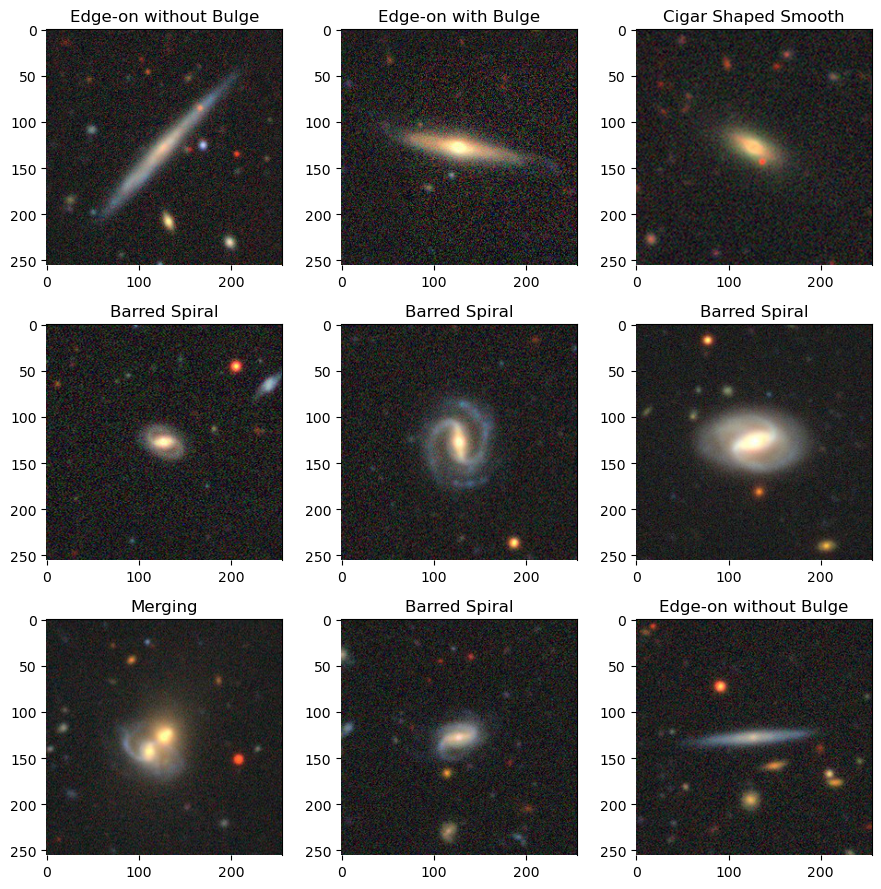

In [101]:
# Plot some images with labels
import matplotlib.pyplot as plt


f, axes = plt.subplots(3, 3, figsize=(9, 9))

rand = random.sample(range(n), 9)
for r, ax in zip(rand, axes.ravel()):

    image, label = images[r], labels[r]
    ax.imshow(image / 255.0)
    label_name = galaxy10cls_lookup(label)
    ax.set_title(label_name)

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()

# Data Preprocessing and Augmentation

As mentioned above, the Galaxy10 dataset only contains 17,736 samples, and the class distribution is moderately imbalanced. Training a deep learning model on such a dataset presents several challenges: the model may overfit the training data, and lack in its generalization ability; it may perform especially poorly on minority classes; and it may be unable to learn complex features in the data. 

To address these issues, I will apply **data augmentation** to modify the existing training data using techniques such as rotation, scaling and translation, with the goal of increasing the variability of the training dataset to improve model generalizability. 

In [359]:
# Create a custom dataset class and initialize dataset object
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from PIL import Image
import math


class Galaxy10Dataset(Dataset):
    def __init__(self, images, labels, transforms=None, train=True, split=0.3):
        super().__init__()
        self.images = images
        self.labels = labels

        # Fallback to default if no transforms are specified
        self.transforms = transforms if transforms else Compose([ToTensor()])

        # Train test splitting
        l = len(self.labels)
        val_len = math.floor(l * split)
        train_len = l - val_len
        if train:
            self.images = self.images[0:train_len]
            self.labels = self.labels[0:train_len]
        else:
            self.images = self.images[train_len:l]
            self.labels = self.labels[train_len:l]

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].astype("uint8"))
        label = self.labels[idx]
        return self.transforms(image), label

    def __len__(self):
        return len(self.labels)

In [360]:
# Shuffle dataset before splitting into training and validation sets
import random


tmp = list(zip(images, labels))
random.shuffle(tmp)
images, labels = zip(*tmp)

In [361]:
from torchvision.transforms.v2 import RandomAffine


# Define augmentation routine for training data 
transforms_train = Compose([
    RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.99, 1)),
    ToTensor()
])

# Generate training and validation dataset objects
gal_train_ds = Galaxy10Dataset(images=images, labels=labels, transforms=transforms_train)
gal_valid_ds = Galaxy10Dataset(images=images, labels=labels, train=False, transforms=None)

In [362]:
# Initialize dataloader
from torch.utils.data import DataLoader


batch_size = 32
gal_train_dl = DataLoader(gal_train_ds, batch_size=batch_size)
gal_valid_dl = DataLoader(gal_valid_ds, batch_size=batch_size)

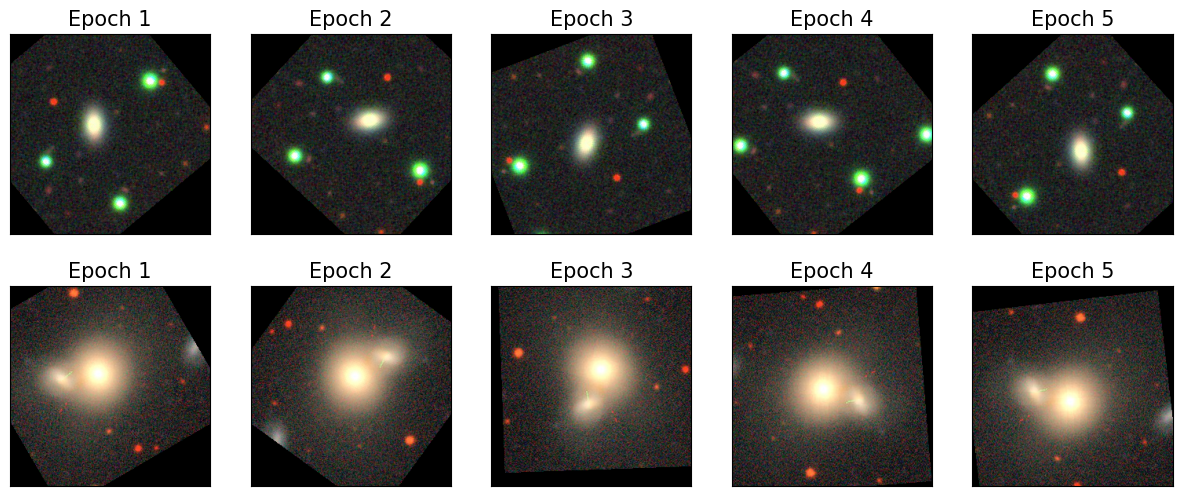

In [363]:
# Inspect two samples of augmented training data across five epochs
fig = plt.figure(figsize=(15, 6))
for epoch in range(5):
    img_batch, label_batch = next(iter(gal_train_dl))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, epoch+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Epoch {epoch+1}", size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, epoch+6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Epoch {epoch+1}", size=15)
    ax.imshow(img.permute(1, 2, 0))

plt.show()

In [364]:
# Get sample of inputs and targets from train dataloader
for inputs, targets in gal_train_dl:
    print(inputs.shape)
    print(targets.shape)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32])


# Baseline MLP Models

As a starting point, I will implement a simple **multilayer perceptron (MLP)** which flattens the input image and passes it through a single fully connected classification layer. While this model is unlikely to achieve a high accuracy score$-$since it entirely ignores spatial structure$-$it will serve as a useful lower-bound for comparison with more complex models, spatially aware models, such as a **convolutional neural network (CNN)**. 

In [80]:
# Set up GPU
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [369]:
# Define training and validation loops
def train(model, optimizer, loss_fn, num_epochs=5, return_history=False):
    log_epochs = 1
    
    train_accuracy_hist = [0] * num_epochs
    train_loss_hist = [0] * num_epochs
    valid_accuracy_hist = [0] * num_epochs
    valid_loss_hist = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in gal_train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            is_correct = (torch.argmax(pred, 1) == y_batch).float().mean()
            train_loss_hist[epoch] += loss.item()
            train_accuracy_hist[epoch] += is_correct
    
        train_loss_hist[epoch] /= len(gal_train_ds)/batch_size
        train_accuracy_hist[epoch] /= len(gal_train_ds)/batch_size
    
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in gal_valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch) 
                
                is_correct = (torch.argmax(pred, 1) == y_batch).float().mean()
                valid_loss_hist[epoch] += loss.item()
                valid_accuracy_hist[epoch] += is_correct 
    
            valid_loss_hist[epoch] /= len(gal_valid_ds)/batch_size
            valid_accuracy_hist[epoch] /= len(gal_valid_ds)/batch_size
    
        if epoch % log_epochs == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]:")
            print(f"\tTrain Loss: {train_loss_hist[epoch]:0.4f}\tTrain Accuracy: {train_accuracy_hist[epoch]:0.4f}")
            print(f"\tValid Loss: {valid_loss_hist[epoch]:0.4f}\tValid Accuracy: {valid_accuracy_hist[epoch]:0.4f}")

    if return_history:
        return train_loss_hist, train_accuracy_hist, valid_loss_hist, valid_accuracy_hist

In [323]:
# Define and train simple MLP model
from torch import nn 
from torch import optim


mlp = nn.Sequential(nn.Flatten(), nn.Linear(256*256*3, 10))
mlp = mlp.to(device)

n_params = sum(p.numel() for p in mlp.parameters())
print(f"Number of parameters: {n_params}")

loss_fn = nn.CrossEntropyLoss() # expects logits
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

train(mlp, optimizer, loss_fn)

Epoch [1/5]:
	Train Loss: 9.3703	Train Accuracy: 0.1762
	Valid Loss: 8.3097	Valid Accuracy: 0.2376
Epoch [2/5]:
	Train Loss: 4.9017	Train Accuracy: 0.2001
	Valid Loss: 5.3736	Valid Accuracy: 0.1855
Epoch [3/5]:
	Train Loss: 4.6050	Train Accuracy: 0.2035
	Valid Loss: 5.4842	Valid Accuracy: 0.1919
Epoch [4/5]:
	Train Loss: 4.7045	Train Accuracy: 0.2118
	Valid Loss: 8.3153	Valid Accuracy: 0.0908
Epoch [5/5]:
	Train Loss: 5.4490	Train Accuracy: 0.2061
	Valid Loss: 8.0156	Valid Accuracy: 0.0972


In the first epoch, the simple MLP model achieved a validation accuracy of approximately 0.24, which is ~2.4x better than random chance. However, the model's validation accuracy decreased every epoch, suggesting overfitting. In the fifth epoch, the model's validation accuracy deteriorated to ~0.1, which is no better than as guessing. 

This highlights the limitations of a model incapable of understanding spatial relationships in the data. While this suggests that CNNs are likely more appropriate for this classification task, I will first explore whether an MLP with a hidden layer and a ReLU activation function, capable of capturing non-linearities in the data, might perform better than the simple MLP. 

In [325]:
# Define an MLP with a single hidden layer and ReLU activation function
mlp_2 = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(256*256*3, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)
mlp_2 = mlp_2.to(device)

n_params = sum(p.numel() for p in mlp_2.parameters())
print(f"Number of parameters: {n_params}")

loss_fn = nn.CrossEntropyLoss() # expects logits
optimizer = optim.Adam(mlp_2.parameters(), lr=0.001)

train(mlp_2, optimizer, loss_fn)

Epoch [1/5]:
	Train Loss: 3.8871	Train Accuracy: 0.1335
	Valid Loss: 2.3023	Valid Accuracy: 0.1455
Epoch [2/5]:
	Train Loss: 2.2658	Train Accuracy: 0.1507
	Valid Loss: 2.2822	Valid Accuracy: 0.1455
Epoch [3/5]:
	Train Loss: 2.2492	Train Accuracy: 0.1509
	Valid Loss: 2.2697	Valid Accuracy: 0.1455
Epoch [4/5]:
	Train Loss: 2.2451	Train Accuracy: 0.1505
	Valid Loss: 2.2620	Valid Accuracy: 0.1455
Epoch [5/5]:
	Train Loss: 2.2317	Train Accuracy: 0.1507
	Valid Loss: 2.2574	Valid Accuracy: 0.1455


It does not appear that the slightly more sophisticated MLP performs a lot better than the simple MLP. As a next step I will explore CNN architectures capable of extracting relavant spatial features from image data.

# Baseline CNN models

I will start with a **basic CNN architecture** consisting of two convolutional layers with ReLU activation and max pooling, followed by a fully connected classification layer. Again, this model is also unlikely to perform a lot better than random chance, but it will serve as a benchmark for more complex models I hope to explore later. 

In [357]:
# Define a simple CNN model with two convolutional and pooling layers
cnn = torch.nn.Sequential()

cnn.add_module("conv1", torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"))
cnn.add_module("relu1", torch.nn.ReLU())
cnn.add_module("pooling1", torch.nn.MaxPool2d(2))

cnn.add_module("conv2", torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"))
cnn.add_module("relu2", torch.nn.ReLU())
cnn.add_module("pooling2", torch.nn.MaxPool2d(2))

cnn.add_module("flatten", torch.nn.Flatten())

linear_input_size = cnn(inputs).shape[1]
cnn.add_module("linear1", torch.nn.Linear(linear_input_size, 10))

n_params = sum(p.numel() for p in cnn.parameters())
print(f"Number of parameters: {n_params}")

cnn = cnn.to(device)

# Define optimizer and loss functions
loss_fn = nn.CrossEntropyLoss() # expects logits, not probabilities
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

train(cnn, optimizer, loss_fn)

Number of parameters: 2640842
Epoch [1/5]:
	Train Loss: 2.0636	Train Accuracy: 0.2507
	Valid Loss: 1.9754	Valid Accuracy: 0.2455
Epoch [2/5]:
	Train Loss: 1.8559	Train Accuracy: 0.3152
	Valid Loss: 1.7847	Valid Accuracy: 0.3432
Epoch [3/5]:
	Train Loss: 1.7551	Train Accuracy: 0.3580
	Valid Loss: 1.7209	Valid Accuracy: 0.3675
Epoch [4/5]:
	Train Loss: 1.7029	Train Accuracy: 0.3816
	Valid Loss: 1.6673	Valid Accuracy: 0.3970
Epoch [5/5]:
	Train Loss: 1.6650	Train Accuracy: 0.3975
	Valid Loss: 1.6485	Valid Accuracy: 0.3992


# Deeper CNN Models

The two layer CNN performs a lot better than random chance on the training and validation sets; its validation accuracy increased per epoch from 0.23 in the first to 0.4 in the fifth. 

On the strength of this promising result, I will turn to **deeper CNN architectures** with three and four convolutional layers, to observe how adding depth to the model may improve the model's ability to extract spatial features and make accurate class predictions. 

In [332]:
# Increase depth to three convolutional and pooling layers
cnn_3 = torch.nn.Sequential()

cnn_3.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"))
cnn_3.add_module("relu1", nn.ReLU())
cnn_3.add_module("pooling1", nn.MaxPool2d(2))

cnn_3.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"))
cnn_3.add_module("relu2", tnn.ReLU())
cnn_3.add_module("pooling2", nn.MaxPool2d(2))

cnn_3.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"))
cnn_3.add_module("relu3", nn.ReLU())
cnn_3.add_module("pooling3", nn.MaxPool2d(2))

cnn_3.add_module("flatten", nn.Flatten())

linear_input_size = cnn_3(inputs).shape[1]
cnn_3.add_module("linear1", nn.Linear(linear_input_size, 10))

n_params = sum(p.numel() for p in cnn_3.parameters())
print(f"Number of parameters: {n_params}")

cnn_3 = cnn_3.to(device)

# Define optimizer and loss functions
loss_fn = nn.CrossEntropyLoss() # expects logits, not probabilities
optimizer = optim.Adam(cnn_3.parameters(), lr=0.001)

train(cnn_3, optimizer, loss_fn)

Number of parameters: 1403978
Epoch [1/5]:
	Train Loss: 2.0086	Train Accuracy: 0.2429
	Valid Loss: 1.9399	Valid Accuracy: 0.2684
Epoch [2/5]:
	Train Loss: 1.8423	Train Accuracy: 0.3225
	Valid Loss: 1.8763	Valid Accuracy: 0.3481
Epoch [3/5]:
	Train Loss: 1.6932	Train Accuracy: 0.3870
	Valid Loss: 1.6618	Valid Accuracy: 0.4071
Epoch [4/5]:
	Train Loss: 1.5823	Train Accuracy: 0.4262
	Valid Loss: 1.5813	Valid Accuracy: 0.4357
Epoch [5/5]:
	Train Loss: 1.5226	Train Accuracy: 0.4498
	Valid Loss: 1.5059	Valid Accuracy: 0.4598


The three layer CNN's final validation accuracy is nearly 0.46, dramatically better than random chance for a ten class classification problem. It appears that increasing model depth may improve model performance. 

Next, I will create a four layer CNN, and train it over 50 epochs, to see when and at what level its performance begins to plateau. 

In [371]:
# Increase depth to four convolutional and pooling layers
cnn_4 = nn.Sequential()

cnn_4.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"))
cnn_4.add_module("relu1", nn.ReLU())
cnn_4.add_module("pooling1", nn.MaxPool2d(2))

cnn_4.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"))
cnn_4.add_module("relu2", nn.ReLU())
cnn_4.add_module("pooling2", nn.MaxPool2d(2))

cnn_4.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"))
cnn_4.add_module("relu3", nn.ReLU())
cnn_4.add_module("pooling3", nn.MaxPool2d(2))

cnn_4.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"))
cnn_4.add_module("relu4", nn.ReLU())
cnn_4.add_module("pooling4", nn.MaxPool2d(2))

cnn_4.add_module("flatten", nn.Flatten())

linear_input_size = cnn_4(inputs).shape[1]
cnn_4.add_module("linear1", nn.Linear(linear_input_size, 10))

n_params = sum(p.numel() for p in cnn_4.parameters())
print(f"Number of parameters: {n_params}")

cnn_4 = cnn_4.to(device)

# Define optimizer and loss functions
loss_fn = nn.CrossEntropyLoss() # expects logits, not probabilities
optimizer = optim.Adam(cnn_4.parameters(), lr=0.001)

train_loss_hist, train_accuracy_hist, valid_loss_hist, valid_accuracy_hist = train(
    model=cnn_4, optimizer=optimizer, loss_fn=loss_fn, num_epochs=50, return_history=True)

Number of parameters: 1043786
Epoch [1/50]:
	Train Loss: 1.9904	Train Accuracy: 0.2560
	Valid Loss: 1.7914	Valid Accuracy: 0.3365
Epoch [2/50]:
	Train Loss: 1.6619	Train Accuracy: 0.3946
	Valid Loss: 1.4927	Valid Accuracy: 0.4436
Epoch [3/50]:
	Train Loss: 1.4911	Train Accuracy: 0.4572
	Valid Loss: 1.3845	Valid Accuracy: 0.4812
Epoch [4/50]:
	Train Loss: 1.3563	Train Accuracy: 0.5095
	Valid Loss: 1.2657	Valid Accuracy: 0.5453
Epoch [5/50]:
	Train Loss: 1.2694	Train Accuracy: 0.5495
	Valid Loss: 1.2124	Valid Accuracy: 0.5712
Epoch [6/50]:
	Train Loss: 1.1947	Train Accuracy: 0.5744
	Valid Loss: 1.1589	Valid Accuracy: 0.5784
Epoch [7/50]:
	Train Loss: 1.1330	Train Accuracy: 0.6024
	Valid Loss: 1.0650	Valid Accuracy: 0.6329
Epoch [8/50]:
	Train Loss: 1.0805	Train Accuracy: 0.6249
	Valid Loss: 1.0018	Valid Accuracy: 0.6635
Epoch [9/50]:
	Train Loss: 1.0461	Train Accuracy: 0.6396
	Valid Loss: 1.0044	Valid Accuracy: 0.6594
Epoch [10/50]:
	Train Loss: 1.0142	Train Accuracy: 0.6534
	Valid Loss:

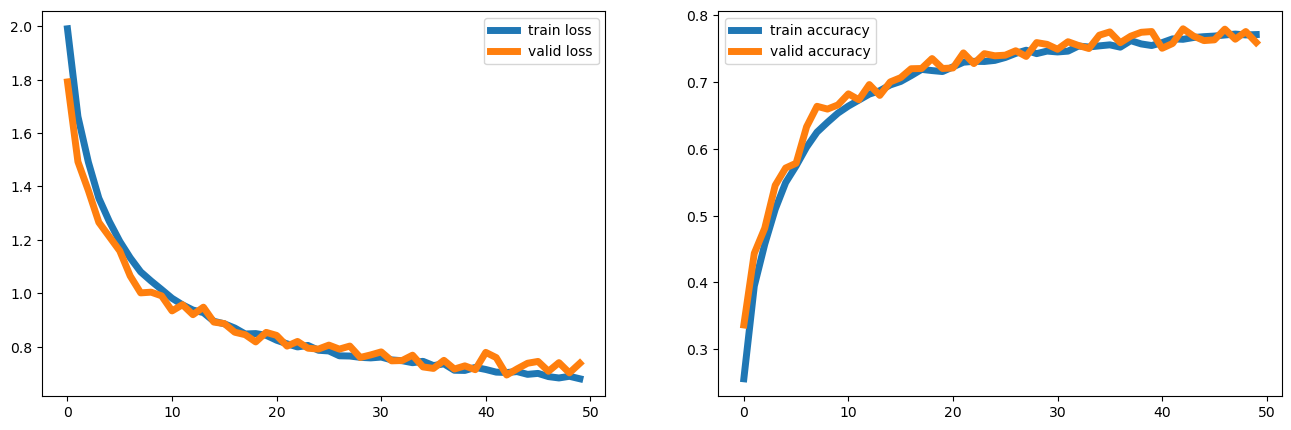

In [380]:
# Plot model performance
fig = plt.figure(figsize=(16, 5))

fig.add_subplot(1, 2, 1)
plt.plot(train_loss_hist, lw=5, label="train loss")
plt.plot(valid_loss_hist, lw=5, label="valid loss")
plt.legend()

train_accuracy_hist_ = [i.item() for i in train_accuracy_hist]
valid_accuracy_hist_ = [i.item() for i in valid_accuracy_hist]

fig.add_subplot(1, 2, 2)
plt.plot(train_accuracy_hist_, lw=5, label="train accuracy")
plt.plot(valid_accuracy_hist_, lw=5, label="valid accuracy")
plt.legend()

plt.show()

In [379]:
train_accuracy_hist[0].item()

0.25596004724502563

I will now inspect the more performant four layer model's predictions, to assess the nature of the samples it is successfully able to predict versus those it is not. 

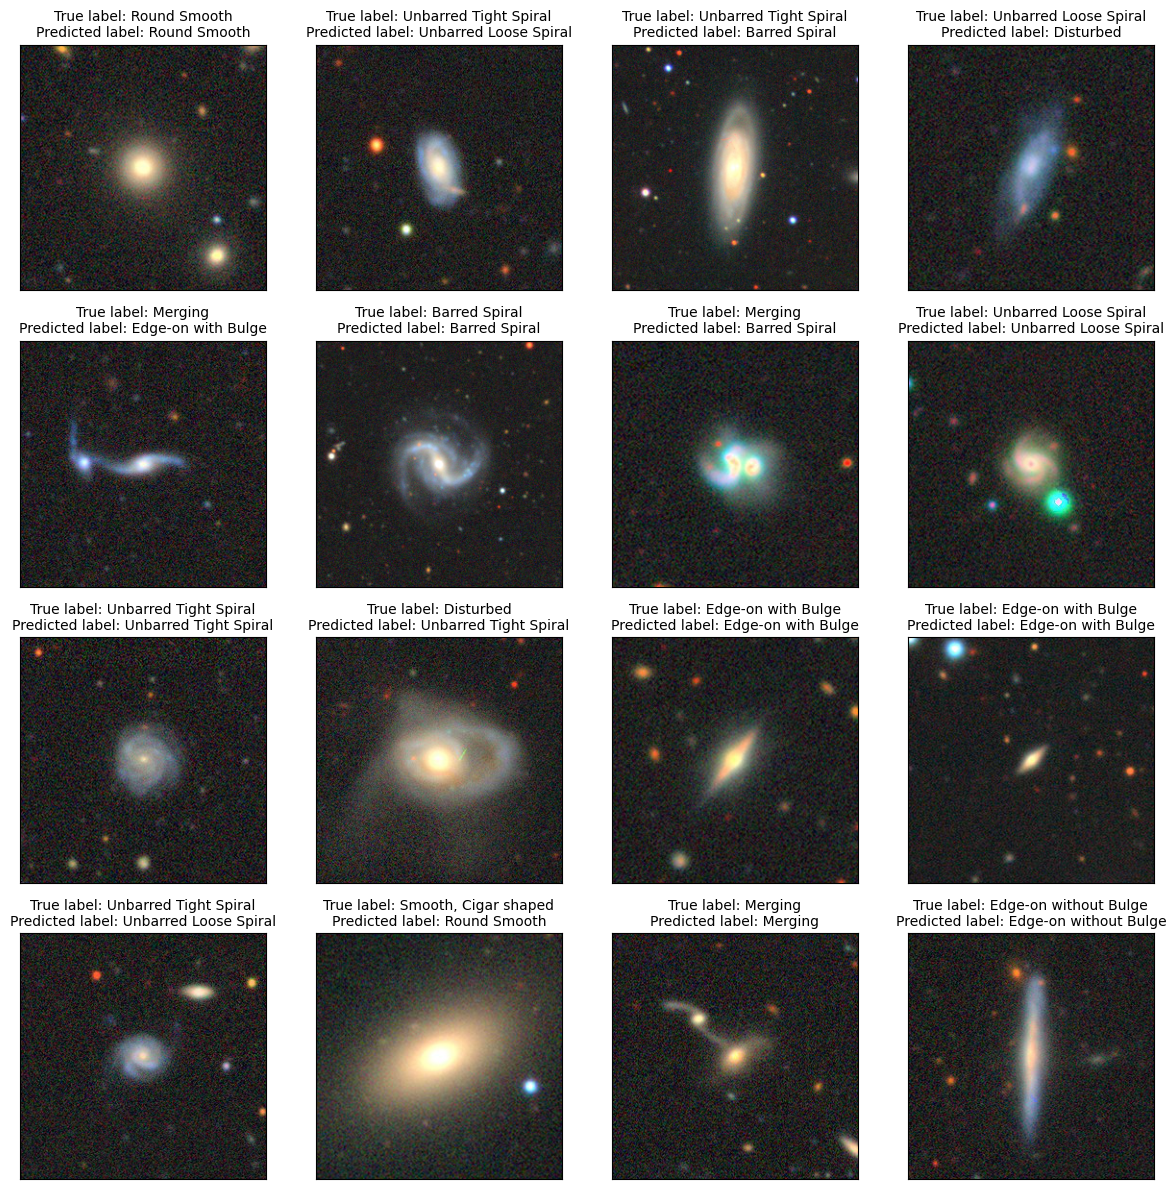

In [366]:
# Plot validation samples, true labels and model predictions
plt.figure(figsize=(12, 12))

for i in range(16):
    xi = gal_valid_ds[i][0].unsqueeze(0)
    true_label = gal_valid_ds[i][1]

    image = xi.squeeze(0).permute(1, 2, 0).numpy()

    xi = xi.to(device)
    
    with torch.no_grad():
        pred = torch.argmax(cnn_4(xi), 1).item()

    true_label = galaxy10cls_lookup(true_label)
    pred_label = galaxy10cls_lookup(pred)

    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap="binary")
    plt.title(f"True label: {true_label}\nPredicted label: {pred_label}", fontsize=10)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

Interestingly, the model's misclassifications appear qualitatively reasonable. It sometimes mistakes merging galaxies for cigar shaped galaxies, confuses disturbed and merging galaxies, and misclassifies edge-on galaxies without a bulge as unbarred loose spiral galaxies. The errors do not appear random or pathological, but instead reflect the intrinsic difficulty of galaxy classification. This strengthens my confidence in the CNN's capacity to learn meaningful visual features in the data. 

In [358]:
# Increase depth to five convolutional and pooling layers
cnn_5 = nn.Sequential()

cnn_5.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"))
cnn_5.add_module("relu1", nn.ReLU())
cnn_5.add_module("pooling1", nn.MaxPool2d(2))

cnn_5.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"))
cnn_5.add_module("relu2", nn.ReLU())
cnn_5.add_module("pooling2", nn.MaxPool2d(2))

cnn_5.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"))
cnn_5.add_module("relu3", nn.ReLU())
cnn_5.add_module("pooling3", nn.MaxPool2d(2))

cnn_5.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"))
cnn_5.add_module("relu4", nn.ReLU())
cnn_5.add_module("pooling4", nn.MaxPool2d(2))

cnn_5.add_module("conv5", nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same"))
cnn_5.add_module("relu5", nn.ReLU())
cnn_5.add_module("pooling5", nn.MaxPool2d(2))

cnn_5.add_module("flatten", nn.Flatten())

linear_input_size = cnn_5(inputs).shape[1]
cnn_5.add_module("linear1", nn.Linear(linear_input_size, 10))

n_params = sum(p.numel() for p in cnn_5.parameters())
print(f"Number of parameters: {n_params}")

cnn_5 = cnn_5.to(device)

# Define optimizer and loss functions
loss_fn = nn.CrossEntropyLoss() # expects logits, not probabilities
optimizer = optim.Adam(cnn_5.parameters(), lr=0.001)

train(cnn_5, optimizer, loss_fn, 10)

Number of parameters: 1896266
Epoch [1/10]:
	Train Loss: 2.0438	Train Accuracy: 0.2266
	Valid Loss: 1.8515	Valid Accuracy: 0.3100
Epoch [2/10]:
	Train Loss: 1.7792	Train Accuracy: 0.3247
	Valid Loss: 1.7211	Valid Accuracy: 0.3538
Epoch [3/10]:
	Train Loss: 1.6403	Train Accuracy: 0.3896
	Valid Loss: 1.5523	Valid Accuracy: 0.4263
Epoch [4/10]:
	Train Loss: 1.5215	Train Accuracy: 0.4303
	Valid Loss: 1.4838	Valid Accuracy: 0.4570
Epoch [5/10]:
	Train Loss: 1.4424	Train Accuracy: 0.4653
	Valid Loss: 1.4178	Valid Accuracy: 0.4763
Epoch [6/10]:
	Train Loss: 1.3658	Train Accuracy: 0.5006
	Valid Loss: 1.3521	Valid Accuracy: 0.5021
Epoch [7/10]:
	Train Loss: 1.2837	Train Accuracy: 0.5352
	Valid Loss: 1.2527	Valid Accuracy: 0.5445
Epoch [8/10]:
	Train Loss: 1.2124	Train Accuracy: 0.5666
	Valid Loss: 1.2287	Valid Accuracy: 0.5600
Epoch [9/10]:
	Train Loss: 1.1365	Train Accuracy: 0.6023
	Valid Loss: 1.1119	Valid Accuracy: 0.6064
Epoch [10/10]:
	Train Loss: 1.0609	Train Accuracy: 0.6293
	Valid Loss:

While increasing the model depth from three to four layers improved performance, increasing the depth from four to five did not result in a significant performance improvement. 

One explanation for this is that the five layer model has markedly more parameters than the four layer model -- 1.89M vs 1.04M, and this additional complexity likely made optimization more difficult, resulting in the model fitting to noise rather than meaningful patterns in the data. 

I will now try to refine the deeper CNN models I have explored by applying regularization techniques, increasing the number of training epochs, and possibly even increasing model depth. 

# Regularization 

In this section, I will explore regularization techniques, including adding dropout layers to the model, and a weight decay parameter to the optimizer, to reduce overfitting. 

I will start by adding a weight decay parameter to the optimizer. I will also increase the number of training epochs from five to ten, to allow the deeper model more time to learn patterns in the data and reduce training loss. 

Weight decay penalizes large weights by adding an L2 regularization term to the loss function. In other words, it adds a term $\lambda * ||w||^2$ to the loss function to discourage overly large weights. Typically, the weight decay parameter in the Adam optimizer is set to 0.0001. I will start with this typical value. 

In [354]:
# Increase depth to five convolutional and pooling layers
cnn_5 = nn.Sequential()

cnn_5.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"))
cnn_5.add_module("relu1", nn.ReLU())
cnn_5.add_module("pooling1", nn.MaxPool2d(2))

cnn_5.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"))
cnn_5.add_module("relu2", nn.ReLU())
cnn_5.add_module("pooling2", nn.MaxPool2d(2))

cnn_5.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"))
cnn_5.add_module("relu3", nn.ReLU())
cnn_5.add_module("pooling3", nn.MaxPool2d(2))

cnn_5.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"))
cnn_5.add_module("relu4", nn.ReLU())
cnn_5.add_module("pooling4", nn.MaxPool2d(2))

cnn_5.add_module("conv5", nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same"))
cnn_5.add_module("relu5", nn.ReLU())
cnn_5.add_module("pooling5", nn.MaxPool2d(2))

cnn_5.add_module("flatten", nn.Flatten())

linear_input_size = cnn_5(inputs).shape[1]
cnn_5.add_module("linear1", nn.Linear(linear_input_size, 10))

n_params = sum(p.numel() for p in cnn_5.parameters())
print(f"Number of parameters: {n_params}")

cnn_5 = cnn_5.to(device)

# Define optimizer and loss functions
loss_fn = nn.CrossEntropyLoss() # expects logits, not probabilities
optimizer = optim.Adam(cnn_5.parameters(), lr=0.001, weight_decay=0.0001)

train(cnn_5, 10)

Number of parameters: 1896266
Epoch [1/10]:
	Train Loss: 2.0372	Train Accuracy: 0.2215
	Valid Loss: 2.0074	Valid Accuracy: 0.2603
Epoch [2/10]:
	Train Loss: 1.8093	Train Accuracy: 0.3189
	Valid Loss: 1.8332	Valid Accuracy: 0.3519
Epoch [3/10]:
	Train Loss: 1.5919	Train Accuracy: 0.4080
	Valid Loss: 1.5808	Valid Accuracy: 0.4184
Epoch [4/10]:
	Train Loss: 1.4571	Train Accuracy: 0.4630
	Valid Loss: 1.5032	Valid Accuracy: 0.4498
Epoch [5/10]:
	Train Loss: 1.3488	Train Accuracy: 0.5080
	Valid Loss: 1.3988	Valid Accuracy: 0.4878
Epoch [6/10]:
	Train Loss: 1.2750	Train Accuracy: 0.5375
	Valid Loss: 1.2468	Valid Accuracy: 0.5419
Epoch [7/10]:
	Train Loss: 1.1971	Train Accuracy: 0.5718
	Valid Loss: 1.2392	Valid Accuracy: 0.5489
Epoch [8/10]:
	Train Loss: 1.1326	Train Accuracy: 0.5955
	Valid Loss: 1.1454	Valid Accuracy: 0.5906
Epoch [9/10]:
	Train Loss: 1.0826	Train Accuracy: 0.6196
	Valid Loss: 1.1082	Valid Accuracy: 0.6077
Epoch [10/10]:
	Train Loss: 1.0406	Train Accuracy: 0.6368
	Valid Loss: